# Dell Laptop Price Analyzer and Sale Predictor

This notebook follows a three-step process to predict the best time to buy a Dell laptop.
1.  **Scrape Dell.com:** Get a list of all current laptop models and their base prices.
2.  **Simulate Historical Data:** Pre-load a realistic two-year (2023-2024) price history for the first 5 laptops. The rest can be simulated on-demand.
3.  **Analyze and Predict:** Interactively select any laptop to view its price history and see a prediction of the top 5 sale weeks, including potential savings.

In [1]:
# Import necessary libraries
import sqlite3
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import os
import random
import time
from bs4 import BeautifulSoup
from IPython.display import display, clear_output

# Interactive components for Jupyter
import ipywidgets as widgets

# Selenium is required for the initial web scraping
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, NoSuchElementException
from webdriver_manager.chrome import ChromeDriverManager

## Database Setup

We'll use a local SQLite database to store the scraped and simulated data. The `setup_database` function initializes the database and clears any old data to ensure a fresh run every time.

In [2]:
def setup_database():
    """Creates/updates the SQLite database and the 'prices' table."""
    conn = sqlite3.connect('laptop_prices.db')
    c = conn.cursor()
    c.execute('''
        CREATE TABLE IF NOT EXISTS prices (
            id INTEGER PRIMARY KEY,
            model TEXT,
            base_model TEXT,
            price REAL,
            date TEXT,
            source TEXT
        )
    ''')
    c.execute("DELETE FROM prices")
    conn.commit()
    conn.close()

def save_price(model, base_model, price, source, date_str=None):
    """Saves a price record to the database."""
    conn = sqlite3.connect('laptop_prices.db')
    c = conn.cursor()
    date = date_str if date_str else datetime.now().strftime('%Y-%m-%d')
    c.execute("INSERT INTO prices (model, base_model, price, date, source) VALUES (?, ?, ?, ?, ?)",
              (model, base_model, price, date, source))
    conn.commit()
    conn.close()

# Initialize the database
setup_database()

## Step 1: Scrape Dell.com for All Current Laptop Models

This function now scrapes **all** available laptops from the Dell website by handling pagination, but only stores their name and base price.

In [ ]:
def scrape_dell_for_options():
    """Scrapes all pages of Dell's website to get a list of all laptops and their base price."""
    LISTING_URL = "https://www.dell.com/en-us/shop/dell-laptops/sr/laptops"
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36")
    options.add_argument('--ignore-certificate-errors')
    options.add_argument('--ignore-ssl-errors')
    
    driver = None
    try:
        driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
        driver.get(LISTING_URL)
        
        laptops_data = []
        page_num = 1
        while True:
            print(f"Scraping page {page_num}...")
            WebDriverWait(driver, 20).until(EC.visibility_of_element_located((By.CSS_SELECTOR, "article.ps-stack")))
            soup = BeautifulSoup(driver.page_source, 'html.parser')
            product_cards = soup.select('article.ps-stack')
            
            for card in product_cards:
                try:
                    name = card.select_one('h3.ps-title a').get_text(strip=True)
                    price_str = card.select_one('span.ps-variant-price-amount').get_text(strip=True).replace('$', '').replace(',', '')
                    price = float(price_str)
                    if not any(d['name'] == name for d in laptops_data):
                        laptops_data.append({'name': name, 'current_price': price})
                except (AttributeError, ValueError, IndexError):
                    continue
            
            try:
                next_button = WebDriverWait(driver, 10).until(
                    EC.presence_of_element_located((By.CSS_SELECTOR, "button[aria-label='Next page']"))
                )
                
                if next_button.get_attribute('aria-disabled') == 'true':
                    print("Next button is disabled. Reached the last page.")
                    break
                
                driver.execute_script("arguments[0].click();", next_button)
                page_num += 1
                time.sleep(5)
            except (TimeoutException, NoSuchElementException):
                print("No 'Next Page' button found. Assuming it's the last page.")
                break

        return laptops_data
    finally:
        if driver:
            driver.quit()

print("Scraping Dell.com for all current laptop models...")
all_laptops = scrape_dell_for_options()
print(f"SUCCESS: Found {len(all_laptops)} laptop models.")
print("Displaying the first 5 laptops as a sample:")
display(pd.DataFrame(all_laptops).head(5))

Scraping Dell.com for all current laptop models...
Scraping page 1...
Scraping page 2...
Scraping page 3...
Scraping page 4...
Scraping page 5...


## Step 2: Pre-load Simulated Historical Data for 2023-2024

To provide a fast initial experience, we will pre-load the two-year price simulation for the first 5 laptops. Data for other laptops will be simulated on-demand when selected.

In [20]:
def simulate_and_process_history(model_name, base_model, base_price):
    """Simulates, cleans, and saves two years (2023-2024) of price history with advanced rules."""
    
    sale_periods = {
        "Prime Day": (28, 0.15), "Back to School": (33, 0.12),
        "Black Friday": (47, 0.25), "Cyber Monday": (48, 0.22),
        "End of Year": (52, 0.20)
    }

    raw_prices = {}
    price = base_price / 1.1 # Start price for 2023
    current_year_baseline = base_price / 1.1

    for i in range(730, 0, -1):
        date = datetime(2024, 12, 31) - timedelta(days=i)
        date_str = date.strftime('%Y-%m-%d')
        
        if date.year == 2023:
            current_year_baseline = base_price / 1.1
        else:
            current_year_baseline = base_price

        price_floor = current_year_baseline * 0.85
        price_ceiling = current_year_baseline * 1.30
        
        if random.random() < 0.07:
            raw_prices[date_str] = None
            continue

        week_of_year = date.isocalendar().week
        is_sale_week = any(week_of_year == w for w, d in sale_periods.values())
        
        simulated_price = price
        
        if is_sale_week:
            discount = next(d for w, d in sale_periods.values() if w == week_of_year)
            simulated_price = current_year_baseline * (1 - discount)
        elif (date.month == 12 and date.day == 31) or (date.month == 1 and date.day == 1):
            increase_factor = 1 + random.uniform(0.0, 0.40)
            simulated_price = price * increase_factor
        elif price >= price_ceiling:
            if random.random() < 0.10: simulated_price = price * (1 - random.uniform(0, 0.07))
        elif price <= price_floor:
            if random.random() < 0.15: simulated_price = price * (1 + random.uniform(0, 0.07))
        elif random.random() < 0.15:
            simulated_price = price * (1 + (random.random() - 0.5) * 2 * 0.05)

        price = simulated_price
        raw_prices[date_str] = price

    df = pd.DataFrame(data={'price': list(raw_prices.values())}, index=pd.to_datetime(list(raw_prices.keys())))
    df['price'] = df['price'].interpolate(method='linear')
    
    for date, row in df.iterrows():
        save_price(model_name, base_model, row['price'], "Simulated", date.strftime('%Y-%m-%d'))

def get_base_model_and_year(full_name):
    match = re.search(r'(.+?)\s*(\d{4})', full_name)
    return (match.group(1).strip(), match.group(2)) if match else (full_name, None)

print("Pre-loading historical data for the first 5 laptops...")
for laptop in all_laptops[:5]:
    base_model, _ = get_base_model_and_year(laptop['name'])
    simulate_and_process_history(laptop['name'], base_model, laptop['current_price'])
print("Pre-loading complete.")

Pre-loading historical data for the first 5 laptops...
Pre-loading complete.


## Step 3: Interactive Analysis and Prediction

Use the dropdown menu below to select any laptop. If its data hasn't been pre-loaded, the simulation will run automatically. The notebook will then display the price history graph, a table of the most recent prices, and a prediction of the best weeks to buy.

--- Analysis for: Dell 16 Plus Laptop ---
Current Scraped Price: $699.99

Top 5 Predicted Sale Periods:


,Week Range,Original Price (Avg),Discounted Price (Min),Average Discount
0,Jun 10 - Jun 16,$652.49,$536.23,17.8%
1,Jan 08 - Jan 14,$619.66,$511.21,17.5%
2,Jun 17 - Jun 23,$684.54,$567.96,17.0%
3,Jun 03 - Jun 09,$640.89,$536.23,16.3%
4,May 27 - Jun 02,$645.98,$540.52,16.3%



Price History Graph (2023-2024):


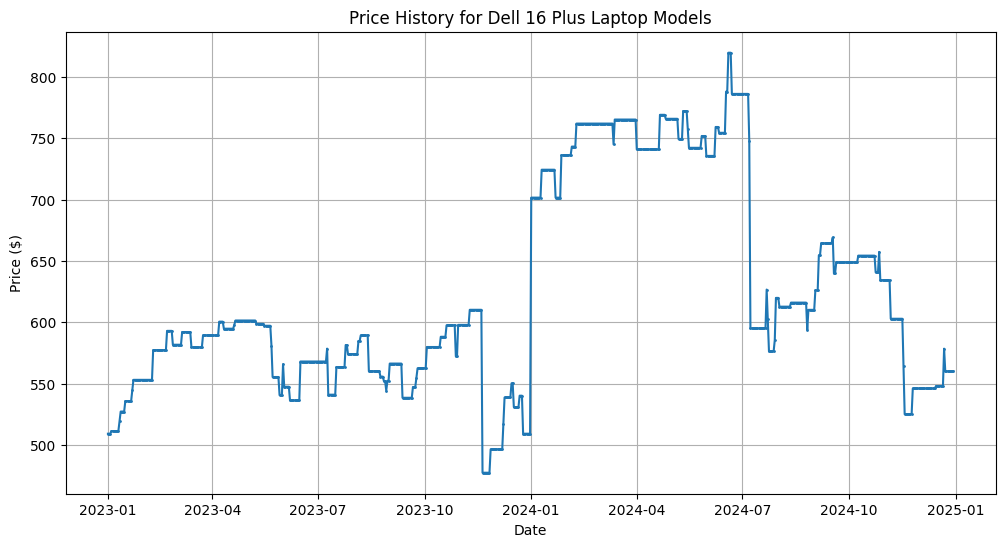


Price History Table (Last 30 days of 2024):


,date,price,week
700,2024-12-01,545.992200,48
701,2024-12-02,545.992200,49
702,2024-12-03,545.992200,49
703,2024-12-04,545.992200,49
704,2024-12-05,545.992200,49
705,2024-12-06,545.992200,49
706,2024-12-07,545.992200,49
707,2024-12-08,545.992200,49
708,2024-12-09,545.992200,50
709,2024-12-10,545.992200,50


In [21]:
def analyze_and_predict(base_model, current_price):
    """Analyzes historical data and predicts future sale periods."""
    conn = sqlite3.connect('laptop_prices.db')
    query = "SELECT date, price FROM prices WHERE base_model = ? ORDER BY date"
    df = pd.read_sql_query(query, conn, params=(base_model,))
    conn.close()

    if len(df) < 30:
        return None, None

    df['date'] = pd.to_datetime(df['date'])
    df['week'] = df['date'].dt.isocalendar().week
    
    weekly_stats = df.groupby('week')['price'].agg(['mean', 'min']).rename(columns={'mean': 'avg_price', 'min': 'min_price'})
    
    weekly_stats['dip'] = (weekly_stats['avg_price'] - weekly_stats['min_price']) / weekly_stats['avg_price']
    
    top_5_sales = weekly_stats[weekly_stats['dip'] > 0.05].nlargest(5, 'dip')
    
    if top_5_sales.empty:
        return df, None
        
    predictions = []
    for week, row in top_5_sales.iterrows():
        start_date_of_week = datetime.strptime(f'2024-{week}-1', "%Y-%W-%w")
        end_date_of_week = start_date_of_week + timedelta(days=6)
        predictions.append({
            "Week Range": f"{start_date_of_week.strftime('%b %d')} - {end_date_of_week.strftime('%b %d')}",
            "Original Price (Avg)": f"${row['avg_price']:.2f}",
            "Discounted Price (Min)": f"${row['min_price']:.2f}",
            "Average Discount": f"{row['dip']:.1%}"
        })
        
    return df, pd.DataFrame(predictions)

# --- Interactive Widget Setup ---
laptop_selector = widgets.Dropdown(
    options=[laptop['name'] for laptop in all_laptops],
    description='Select Laptop:',
    style={'description_width': 'initial'},
    layout={'width': 'max-content'}
)

output = widgets.Output()

def on_laptop_select(change):
    with output:
        clear_output(wait=True)
        selected_laptop_name = change['new']
        laptop_info = next((l for l in all_laptops if l['name'] == selected_laptop_name), None)
        if not laptop_info: return

        base_model, _ = get_base_model_and_year(selected_laptop_name)
        
        # Check if data exists, if not, simulate it on-demand
        conn = sqlite3.connect('laptop_prices.db')
        df_check = pd.read_sql_query("SELECT 1 FROM prices WHERE base_model = ? LIMIT 1", conn, params=(base_model,))
        conn.close()
        if df_check.empty:
            print(f"No pre-loaded data found for {base_model}. Simulating now...")
            simulate_and_process_history(laptop_info['name'], base_model, laptop_info['current_price'])
            print("Simulation complete.")

        print(f"--- Analysis for: {selected_laptop_name} ---")
        print(f"Current Scraped Price: ${laptop_info['current_price']:.2f}\n")

        history_df, predictions_df = analyze_and_predict(base_model, laptop_info['current_price'])

        if predictions_df is not None:
            print("Top 5 Predicted Sale Periods:")
            display(predictions_df)

        if history_df is not None and not history_df.empty:
            print("\nPrice History Graph (2023-2024):")
            plt.figure(figsize=(12, 6))
            plt.plot(history_df['date'], history_df['price'], marker='.', markersize=2, linestyle='-')
            plt.title(f"Price History for {base_model} Models")
            plt.xlabel("Date")
            plt.ylabel("Price ($)")
            plt.grid(True)
            plt.show()

            print("\nPrice History Table (Last 30 days of 2024):")
            display(history_df.tail(30))

laptop_selector.observe(on_laptop_select, names='value')

# Display the widget and trigger the first analysis
display(laptop_selector, output)
on_laptop_select({'new': laptop_selector.value})